In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import List, Dict, Tuple
import copy
import time
import numpy as np
from joblib import Parallel, delayed

In [246]:
MAX_DIST = 2147483647
# random.seed(100)

In [189]:
def create_distance_matrix(df):
    x = df['x'].values
    y = df['y'].values
    x1 = x.reshape((df.shape[0], 1))
    x2 = x.reshape((1, df.shape[0]))
    y1 = y.reshape((df.shape[0], 1))
    y2 = y.reshape((1, df.shape[0]))
    matrix = np.round(np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)).astype(int)
    np.fill_diagonal(matrix, MAX_DIST)
    return matrix

def evaluate(distance_matrix: np.ndarray, path: np.array, costs: np.array) -> int:
    copy_path = copy.deepcopy(path)
    copy_path = np.append(copy_path, copy_path[0])
    distances = distance_matrix[copy_path[:-1], copy_path[1:]]
    path_costs = costs[copy_path[:-1]]
    total_length = np.sum(distances + path_costs)
    return total_length

def random_sequence(distance_matrix: np.ndarray, start_node: int = 0) -> List[int]:
    n = distance_matrix.shape[0]
    num_selected = n // 2 if n % 2 == 0 else (n // 2) + 1
    path = random.sample(list(range(distance_matrix.shape[0])), num_selected)
    return np.array(path)

def get_plot_values(nodes : Dict[int, Tuple[int, int, int]], solution: List[int], costs: List[int]) -> Tuple[List[int], List[int], List[int], List[int], List[int]]:
    x_coords = [nodes[node][0] for node in list(nodes.keys())]
    y_coords = [nodes[node][1] for node in list(nodes.keys())]
    solution = solution + [solution[0]]
    path_x_coords = [nodes[node][0] for node in solution]
    path_y_coords = [nodes[node][1] for node in solution]
    new_costs = [(cost/max(costs))*100 for cost in costs]
    min_cost, max_cost = min(costs), max(costs)
    power = 2
    normalized_costs = [((cost - min_cost) / (max_cost - min_cost)) ** power for cost in costs]
    colors = plt.cm.RdBu(normalized_costs)
    return x_coords, y_coords, new_costs, path_x_coords, path_y_coords, colors

def plot_path(path, nodes, costs):
    x_coords, y_coords, new_costs, path_x_coords, path_y_coords, colors = get_plot_values(nodes, path, costs)
    plt.scatter(x_coords, y_coords, color=colors, marker='o', s=new_costs, label='Cities')
    plt.plot(path_x_coords, path_y_coords, linestyle='-', marker='o', markersize=0, color='blue', label='Path', alpha = 0.7)
    plt.show()

def read_data(filename='TSPA.csv', PATH='./'):
    df = pd.read_csv(PATH + filename, names=["x", "y", "costs"], sep=';', header=None)
    nodes = {}
    for idx, row in enumerate(df.values):
        x, y, cost = map(int, row)
        nodes[idx] = (x, y, cost)
    D = create_distance_matrix(df)
    return nodes, df['costs'].values, D

In [190]:
class Delta:
  def __init__(self, delta_value: int, delta_type: str, values: tuple):
      self.values = values
      self.delta_type = delta_type
      self.delta_value = delta_value

  def create_path(self, path):
      if self.delta_type == 'inter':
          index_of_old_node, new_value = self.values
          modified_path = copy.deepcopy(path)
          modified_path[index_of_old_node] = new_value
          return modified_path
      elif self.delta_type == 'edges':
          n1, n2 = self.values
          if n1 < n2:
              modified_path = np.concatenate((path[:n1], [path[n1]], [path[n2]], path[n1+1:n2][::-1],  path[n2+1:]))
          else:
              modified_path = np.concatenate((path[n2+1:n1], [path[n1]], [path[n2]], path[:n2][::-1], path[n1+1:][::-1]))
          return modified_path
      else:
          raise ValueError("Invalid delta_type!")

In [211]:
def get_candidate_matrix(distance_matrix, n, costs):
    distances = distance_matrix + costs
    for idx in range(distances.shape[0]):
        distances[idx] = np.argpartition(distances[idx], n)
    return distances[:,:n]

In [212]:
def get_candidate_edges(pivot, neighbour, path, distance_matrix, intra_type = 'edges_regular'):
    n1, n2 = pivot, neighbour
    if intra_type == 'edges_regular':
        edge1 = (n1, (n1 + 1) % len(path))
        edge2 = (n2, (n2 + 1) % len(path))
    else:
        edge1 = ((n1 - 1) % len(path), n1)
        edge2 = ((n2 - 1) % len(path), n2)

    index1, index2 = edge1[0], edge2[0]

    if edge1[1] == edge2[0] or edge1[0] == edge2[1]:
        return None

    delta_value = (
        distance_matrix[path[edge1[0]], path[edge2[0]]]
        + distance_matrix[path[edge1[1]], path[edge2[1]]]
    ) - (
        distance_matrix[path[edge1[0]], path[edge1[1]]]
        + distance_matrix[path[edge2[0]], path[edge2[1]]]
    )
    delta = Delta(delta_value, 'edges', (index1, index2))
    return delta

In [213]:
def get_candidate_nodes(pivot, neighbour, path, distance_matrix, costs):
    index_of_old_node, new_node = pivot, neighbour
    delta_value = 0

    prev = int(path[(index_of_old_node - 1) % len(path)])
    next = int(path[(index_of_old_node + 1) % len(path)])

    old_dist = distance_matrix[prev, path[index_of_old_node]] \
              + distance_matrix[path[index_of_old_node], next]
    new_dist = distance_matrix[prev, new_node] \
              + distance_matrix[new_node, next]
    delta_value += new_dist - old_dist  # lower is better

    delta_value += costs[new_node] - costs[path[index_of_old_node]]  # lower is better

    delta = Delta(delta_value, 'inter', (index_of_old_node, new_node))

    return delta

In [214]:
def candidate_intra(pivot, neighbour, path, distance_matrix, costs):
    return [
        get_candidate_edges(pivot, neighbour, path, distance_matrix),
        get_candidate_edges(pivot, neighbour, path, distance_matrix, intra_type='edges_succ')
    ]


def candidate_inter(pivot, neighbour, path, distance_matrix, costs):
    return get_candidate_nodes(pivot, neighbour, path, distance_matrix, costs)

In [224]:
def get_candidate_neighbourhood(
    path,
    distance_matrix,
    candidate_matrix,
    costs
):
    neighbourhood = []
    node_indices = {node: index for index, node in enumerate(path)}
    for vertex_n1 in path:
        candidates = candidate_matrix[vertex_n1]
        for vertex_n2 in candidates:
            # Evaluate all moves involving the addition of edge n1-n2 and the removal of one of the edges adjacent to vertex_n1
            if vertex_n2 in path:
                # Candidate Edges
                # 0 1 2 3 4 5 6 7 8
                # n1 = 1 n2 = 5
                # Option #1 (same as before)
                # 0 1 5 4 3 2 6 7 8
                # Option #2
                # 0 4 3 2 1 5 6 7 8
                neighbourhood.extend(candidate_intra(node_indices[vertex_n1], node_indices[vertex_n2], path, distance_matrix, costs))
            else:
                # Candidate Nodes
                # 0 1 2 3 4 5 6 7 8
                # n1 = 1 n2 = 9
                # 0 9 2 3 4 5 6 7 8
                neighbourhood.append(candidate_inter(node_indices[vertex_n1], vertex_n2, path, distance_matrix, costs))
    neighbourhood = [i for i in neighbourhood if i is not None]
    return np.array(neighbourhood)

In [225]:
def local_search_candidates(
    current_path,
    costs,
    distance_matrix,
    no_candidates
):
    candidate_matrix = get_candidate_matrix(distance_matrix, no_candidates, costs)
    while True:
        neighbourhood = get_candidate_neighbourhood(
            current_path, distance_matrix, candidate_matrix, costs
        )
        min_index = np.argmin([delta.delta_value for delta in neighbourhood])
        best_delta = neighbourhood[min_index]
        if best_delta.delta_value < 0:
            current_path = best_delta.create_path(current_path)
        else:
            break
    return list(current_path)

In [226]:
def evaluate_solution(filename, initial, costs, distance_matrix, no_candidates=10):
    if initial is None:
        initial = random_sequence(distance_matrix)
    start = time.time()
    initial_score = evaluate(distance_matrix, initial, costs)
    path = local_search_candidates(initial, costs, distance_matrix, no_candidates)
    score = evaluate(distance_matrix, path, costs)
    end = time.time()
    return {
        'Filename': filename,
        'Path': path,
        'Initial_score': initial_score,
        'Score': score,
        'Time': (end - start)
    }

# if __name__ == "__main__":
#     test_start = time.time()
#     files = ['TSPA.csv', 'TSPB.csv', 'TSPC.csv', 'TSPD.csv']
#     for filename in files:
#         prefix = "Candidates"
#         mapping_out_files= {
#             'TSPA.csv' : f'{prefix}_TSPA_out.csv',
#             'TSPB.csv' : f'{prefix}_TSPB_out.csv',
#             'TSPC.csv' : f'{prefix}_TSPC_out.csv',
#             'TSPD.csv' : f'{prefix}_TSPD_out.csv'
#         }
#         nodes, costs, distance_matrix = read_data(filename)
        
#         results = Parallel(n_jobs=-1)(delayed(evaluate_solution)(filename, None, costs, distance_matrix)
#                                     for i in range(200)
#                                     )
#         results_df = pd.DataFrame(results)
#         results_df.to_csv(mapping_out_files[filename])
#         test_end = time.time()
#         print(test_end - test_start)

In [260]:
nodes, costs, distance_matrix = read_data("TSPA.csv")

In [261]:
random_init = random_sequence(distance_matrix)
print(evaluate(distance_matrix, random_init, costs))

262090


In [262]:
ls_candidates = local_search_candidates(random_init, costs, distance_matrix, 10)

In [263]:
print(evaluate(distance_matrix, ls_candidates, costs))

83975


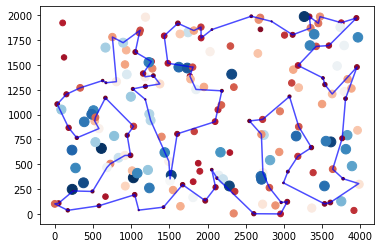

In [264]:
plot_path(ls_candidates, nodes, costs)